

Since the task is mostly written in a purely exploratory way, the following setup was the most time-saving.

- Ubuntu
- Python 3.10
    - setup
        - Pyenv (python-distribution manager)
        - Poetry (dependencies)
    - packages
        - Pandas for data processing and tabulation (Spark could also be an option)
        - Matplotlib and Seaborn for data visualisation
        - pathlib for handling file paths

- Libreoffice Calc for quick overview

# Tools and Languages

In [101]:
import json
import pandas as pd
import numpy as np
import folium, mapclassify, matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
from pathlib import Path

sns.set(rc={"figure.figsize": (16, 5)})
pd.options.display.max_rows = None
pd.options.display.max_colwidth = None
pd.options.mode.chained_assignment = None


In [2]:
bike_dtypes = {
    "ANGELEGT_AM": "object",
    "TATZEIT_ANFANG_DATUM": "object",
    "TATZEIT_ANFANG_STUNDE": "int64",
    "TATZEIT_ENDE_DATUM": "object",
    "TATZEIT_ENDE_STUNDE": "int64",
    "LOR": "object",
    "SCHADENSHOEHE": "int64",
    "VERSUCH": "object",
    "ART_DES_FAHRRADS": "object",
    "DELIKT": "object",
    "ERFASSUNGSGRUND": "object",
}

lor_ort_dtypes = {
    "spatial_name": "object",
    "OTEIL": "object",
    "BEZIRK": "object",
    "FLAECHE_HA": "float64",
}

lor_bzr_dtypes = {
    "BZR_ID": "object",
    "BZR_NAME": "str",
    "BEZ": "object",
    "GROESSE_m2": "float64",
}


In [3]:
path = Path().parent.absolute()
bike_path = path / "data" / "Fahrraddiebstahl.csv"
lor_ort_path = path / "data" / "lor_ortsteile.csv"
lor_bzr_path = path / "data" / "lor_bezirksregionen_2021.csv"
# geojson_path = path / "data" / "bezirksgrenzen.geojson"
geojson_path = path / "data" / "lor_bezirksregionen.geojson"


with open(geojson_path, "r") as file:
    districts = json.load(file)


with open(bike_path, "rb") as file:
    bike_data = pd.read_csv(file, encoding="latin1", dtype=bike_dtypes)

with open(lor_ort_path, "rb") as file:
    lor_ort_data = pd.read_csv(
        file,
        encoding="utf-8",
        dtype=lor_ort_dtypes,
        usecols=["spatial_name", "BEZIRK"],
    )

with open(lor_bzr_path, "rb") as file:
    lor_bzr_data = pd.read_csv(
        file,
        encoding="utf-8",
        dtype=lor_bzr_dtypes,
        usecols=["BZR_ID", "BZR_NAME", "BEZ", "GROESSE_m2"],
    )


In [4]:
# Aufbereitung von timevalues
bike_data["ANGELEGT_AM"] = pd.to_datetime(bike_data["ANGELEGT_AM"], dayfirst=True)
bike_data["TATZEIT_ANFANG_DATUM"] = pd.to_datetime(
    bike_data["TATZEIT_ANFANG_DATUM"], dayfirst=True
) + pd.to_timedelta(bike_data.TATZEIT_ANFANG_STUNDE, unit="h")
bike_data["TATZEIT_ENDE_DATUM"] = pd.to_datetime(
    bike_data["TATZEIT_ENDE_DATUM"], dayfirst=True
) + pd.to_timedelta(bike_data.TATZEIT_ENDE_STUNDE, unit="h")
bike_data["MAX_TATDAUER_STUNDEN"] = (
    bike_data.TATZEIT_ENDE_DATUM - bike_data.TATZEIT_ANFANG_DATUM
).astype("timedelta64[h]")

# Vorbereitung eines keys zum Join mit Bezirksübersichtstabelle
bike_data["BZR_ID"] = bike_data["LOR"].str[0:6]
lor_ort_data["spatial_name"] = lor_ort_data["spatial_name"].str[0:2]
lor_ort_data = lor_ort_data.rename(columns={"spatial_name": "BEZ"})

# some renaming for clarification
bike_data.rename(columns={
    "TATZEIT_ANFANG_DATUM": "ZULETZT_GESEHEN_DATUM", 
    "TATZEIT_ANFANG_STUNDE": "ZULETZT_GESEHEN_STUNDE", 
    "TATZEIT_ENDE_DATUM": "TAT_BEMERKT_DATUM",
    "TATZEIT_ENDE_STUNDE": "TAT_BEMERKT_STUNDE",
    },inplace=True)

In [5]:
# bike_data.info()
# lor_ort_data.info()
# lor_bez_data.info()


In [6]:
merged_df = bike_data.merge(lor_bzr_data, how="right", on="BZR_ID")
merged_df = merged_df.merge(lor_ort_data, how="right", on="BEZ")
merged_df = merged_df.drop_duplicates()
del (
    bike_data,
    lor_ort_data,
    lor_ort_dtypes,
    lor_ort_path,
    lor_bzr_data,
    lor_bzr_dtypes,
    lor_bzr_path,
)


In [7]:
# Übersicht über unique values der einzelnen Spalten

# merged_df.columns.to_list()
for col in merged_df[
    [
        "VERSUCH",
        "ART_DES_FAHRRADS",
        "DELIKT",
        "ERFASSUNGSGRUND",
        "BEZIRK",
    ]
]:
    print(f"{col} : \n {merged_df[col].unique()}")


VERSUCH : 
 ['Nein' 'Ja' 'Unbekannt' nan]
ART_DES_FAHRRADS : 
 ['Herrenfahrrad' 'Damenfahrrad' 'Fahrrad' 'Rennrad' 'Mountainbike'
 'diverse Fahrräder' 'Kinderfahrrad' 'Lastenfahrrad' nan]
DELIKT : 
 ['Fahrraddiebstahl' 'Keller- und Bodeneinbruch' nan]
ERFASSUNGSGRUND : 
 ['Sonstiger schwerer Diebstahl von Fahrrädern'
 'Einfacher Diebstahl von Fahrrädern'
 'Sonstiger schwerer Diebstahl in/aus Keller/Boden von Fahrrädern'
 'Einfacher Diebstahl aus Keller/Boden von Fahrrädern' nan]
BEZIRK : 
 ['Mitte' 'Friedrichshain-Kreuzberg' 'Pankow' 'Charlottenburg-Wilmersdorf'
 'Spandau' 'Steglitz-Zehlendorf' 'Tempelhof-Schöneberg' 'Neukölln'
 'Treptow-Köpenick' 'Marzahn-Hellersdorf' 'Lichtenberg' 'Reinickendorf']


## Exploration
### Assumptions
- Inexpensive bicycles (<= 200€) are less often insured and thefts are therefore less likely to be reported to the police--> The number of unreported cases of cheap stolen bicycles cannot be estimated within the scope of this task, but is potentially high.
- Expensive bicycles (> 750€) are more often insured and thefts therefore very often lead to police registration --> the number of unreported cases of expensive stolen bicycles is potentially very small.
- `TATZEIT` refers to either the last time the stolen bike was seen (`TATZEIT_ANFANG`) or the time the bike was found to be stolen (`TATZEIT_ENDE`)
### Questions
- What are the total numbers?
    - Bicycle thefts in the tens of thousands   
- What are the minima/maxima of the periods?
    - Timerange between 01.01.2022 and 19.02.2023

In [8]:
merged_df.groupby(["DELIKT"], dropna=False).agg(
    {
        "ANGELEGT_AM": ["count", "min", "max"],
        "ZULETZT_GESEHEN_DATUM": ["min", "max"],
        "TAT_BEMERKT_DATUM": ["min", "max"],
    }
).sort_values(by=("ANGELEGT_AM", "count"), ascending=False)


ANGELEGT_AM                        \
                                count        min        max   
DELIKT                                                        
Fahrraddiebstahl                23280 2022-01-01 2023-02-19   
Keller- und Bodeneinbruch        1043 2022-01-02 2023-02-18   
NaN                                 0        NaT        NaT   

                          ZULETZT_GESEHEN_DATUM                      \
                                            min                 max   
DELIKT                                                                
Fahrraddiebstahl                     2022-01-01 2023-02-19 18:00:00   
Keller- und Bodeneinbruch            2022-01-01 2023-02-17 19:00:00   
NaN                                         NaT                 NaT   

                            TAT_BEMERKT_DATUM                      
                                          min                 max  
DELIKT                                                             
Fahrraddiebstahl          2022-01-01 00:00:00 2023-02-19 21:00:00  
Keller- und Bodeneinbruch 2022-01-02 10:00:00 2023-02-18 11:00:00  
NaN                                       NaT                 NaT

What is a reported "attempt"?
- From the following table I conclude that an "attempt" is a thwarted theft.
- Bicycle thefts are reported significantly more often than burglaries, presumably the former are generally much more common

In [9]:
merged_df.groupby("VERSUCH").agg({"SCHADENSHOEHE": ["count", "sum"]})


SCHADENSHOEHE            
                  count         sum
VERSUCH                            
Ja                   67         0.0
Nein              24251  25670279.0
Unbekannt             5      6070.0

In [10]:
merged_df.groupby(["DELIKT"], dropna=False).agg(
    {
        "ANGELEGT_AM": "count",
        "SCHADENSHOEHE": "sum",
        "MAX_TATDAUER_STUNDEN": ["mean", "median", "std"],
    }
).sort_values(by=("ANGELEGT_AM", "count"), ascending=False)


ANGELEGT_AM SCHADENSHOEHE MAX_TATDAUER_STUNDEN  \
                                count           sum                 mean   
DELIKT                                                                     
Fahrraddiebstahl                23280    24185715.0            13.392698   
Keller- und Bodeneinbruch        1043     1490634.0            25.941515   
NaN                                 0           0.0                  NaN   

                                             
                          median        std  
DELIKT                                       
Fahrraddiebstahl             9.0  15.255120  
Keller- und Bodeneinbruch   20.0  20.944022  
NaN                          NaN        NaN

#### Reported cases + damage per district in €
- Marzahn-Hellersdorf has comparatively few thefts, but a disproportionately high number of cellar burglaries (secure cellars/floors better?)
- The average reported damage amounts indicate medium- to high-value bicycle models
- Damage totals for cellar and floor burglaries generally higher than for simple thefts (is damage calculated differently here?)
- Middle seems to have the most expensive bikes on average

In [104]:
merged_df.pivot_table(
    index="BZR_NAME",
    columns="DELIKT",
    aggfunc={"SCHADENSHOEHE": ["count", "sum", "median", "mean"]},
    dropna=False,
).sort_values(by=("SCHADENSHOEHE", "count", "Fahrraddiebstahl"), ascending=False).head(20)


SCHADENSHOEHE                            \
                                      count                             
DELIKT                     Fahrraddiebstahl Keller- und Bodeneinbruch   
BZR_NAME                                                                
Tempelhofer Vorstadt                  911.0                      12.0   
Alexanderplatz                        753.0                      23.0   
Wedding Zentrum                       657.0                      15.0   
Frankfurter Allee Süd FK              612.0                      26.0   
Otto-Suhr-Allee/Kantstraße            519.0                      13.0   
Südliche Luisenstadt                  461.0                      14.0   
Südliche  Friedrichstadt              453.0                       7.0   
Neuköllner Mitte/Zentrum              414.0                       6.0   
Reuterstraße                          407.0                       4.0   
Volkspark Wilmersdorf                 396.0                      20.0   
Schöneberg Nordwest                   379.0                      13.0   
Prenzlauer Berg Nord                  366.0                      13.0   
Rixdorf                               365.0                       8.0   
Lietzenburger Straße                  364.0                       6.0   
Moabit Ost                            360.0                      11.0   
Karl-Marx-Allee Süd                   355.0                      18.0   
Schillerpromenade                     352.0                       7.0   
Pankow Zentrum                        351.0                       6.0   
Prenzlauer Berg Nordwest              338.0                       8.0   
Brunnenstraße Nord                    338.0                      19.0   

                                                                       \
                                       mean                             
DELIKT                     Fahrraddiebstahl Keller- und Bodeneinbruch   
BZR_NAME                                                                
Tempelhofer Vorstadt             938.716795               1769.250000   
Alexanderplatz                  1194.464807               1256.608696   
Wedding Zentrum                 1045.162861               1284.400000   
Frankfurter Allee Süd FK        1074.148693               1362.500000   
Otto-Suhr-Allee/Kantstraße      1084.595376               2013.769231   
Südliche Luisenstadt             915.329718               1519.928571   
Südliche  Friedrichstadt        1156.878587                518.571429   
Neuköllner Mitte/Zentrum         993.473430                983.500000   
Reuterstraße                     938.343980               1582.500000   
Volkspark Wilmersdorf           1298.196970               2345.000000   
Schöneberg Nordwest             1109.556728               1014.923077   
Prenzlauer Berg Nord             963.765027                605.461538   
Rixdorf                          973.619178               1410.250000   
Lietzenburger Straße            1187.445055               2117.166667   
Moabit Ost                      1013.572222               2671.818182   
Karl-Marx-Allee Süd             1049.616901               1123.222222   
Schillerpromenade               1022.139205               1163.428571   
Pankow Zentrum                   880.076923                843.666667   
Prenzlauer Berg Nordwest        1073.289941               1084.375000   
Brunnenstraße Nord               948.470414               1447.421053   

                                                                       \
                                     median                             
DELIKT                     Fahrraddiebstahl Keller- und Bodeneinbruch   
BZR_NAME                                                                
Tempelhofer Vorstadt                  700.0                    1276.5   
Alexanderplatz                        900.0                     700.0   
Wedding Zentrum                       749.0                    1300.0   
Frankfurter A

In [99]:
aggregation_df = merged_df.groupby("BZR_NAME").agg(
    count=("ANGELEGT_AM", np.count_nonzero),
    mean_dmg=("SCHADENSHOEHE", np.mean),
    max_dmg=("SCHADENSHOEHE", np.max),
    sum_dmg=("SCHADENSHOEHE", np.sum),
    last_reported=("ZULETZT_GESEHEN_DATUM", np.max),
).reset_index()

geo_df = gpd.GeoDataFrame.from_features(
    districts["features"]
).merge(aggregation_df, left_on="BEZIRKSREG", right_on="BZR_NAME", how="left").set_index("BEZIRKSREG").set_crs("EPSG:25833", allow_override=True)

geo_df["FLAECHENGR"] = geo_df["FLAECHENGR"].apply(lambda x: f"{x/1000000:,.2f} km²")
geo_df["count_tooltip"] = geo_df["count"].apply(lambda x: x if not np.isnan(x) else 0) 
geo_df["mean_dmg"] = geo_df["mean_dmg"].apply(lambda x: f"{x:,.2f}€" if not np.isnan(x) else "0") 
geo_df["max_dmg"] = geo_df["max_dmg"].apply(lambda x: f"{x:,.2f}€" if not np.isnan(x) else "0") 
geo_df["sum_dmg"] = geo_df["sum_dmg"].apply(lambda x: f"{x:,.2f}€" if not np.isnan(x) else "0") 
geo_df["last_reported"] = geo_df["last_reported"].apply(lambda x: x if not pd.isnull(x) else "no theft reported").astype("str")

geo_df.explore(
    column = "count",
    popup=True, # show all values in popup (on click)
    tooltip=["BEZIRKSREG", "BEZIRKSNAM", "FLAECHENGR", 'count_tooltip', 'mean_dmg', 'max_dmg', 'sum_dmg', 'last_reported'],
    tiles="CartoDB positron", # use "CartoDB positron" tiles
    cmap="OrRd", 
    style_kwds=dict(
        color="black", 
        weight=0.5), # use black outline
    tooltip_kwds=dict(
        aliases=["subregion", "district", "size", 'count', 'mean damage', 'max damage', 'total damage', 'last theft'],
    )
)

- Serious bicycle theft seems to be the main reason for the theft.
- Grand bike theft = expensive bike = higher damage?
    - Does it make more sense to file a complaint because of the insurance sum?

In [12]:
merged_df.pivot_table(
    index="BEZIRK",
    columns="ERFASSUNGSGRUND",
    aggfunc={"SCHADENSHOEHE": ["count", "median"]},
).sort_values(
    by=("SCHADENSHOEHE", "count", "Sonstiger schwerer Diebstahl von Fahrrädern"),
    ascending=False,
)


SCHADENSHOEHE  \
                                                                         count   
ERFASSUNGSGRUND            Einfacher Diebstahl aus Keller/Boden von Fahrrädern   
BEZIRK                                                                           
Mitte                                                                      5.0   
Friedrichshain-Kreuzberg                                                   3.0   
Pankow                                                                     6.0   
Charlottenburg-Wilmersdorf                                                 3.0   
Tempelhof-Schöneberg                                                       4.0   
Neukölln                                                                   NaN   
Treptow-Köpenick                                                           3.0   
Steglitz-Zehlendorf                                                        4.0   
Lichtenberg                                                                3.0   
Reinickendorf                                                              NaN   
Marzahn-Hellersdorf                                                        9.0   
Spandau                                                                    NaN   

                                                               \
                                                                
ERFASSUNGSGRUND            Einfacher Diebstahl von Fahrrädern   
BEZIRK                                                          
Mitte                                                   201.0   
Friedrichshain-Kreuzberg                                199.0   
Pankow                                                  138.0   
Charlottenburg-Wilmersdorf                              150.0   
Tempelhof-Schöneberg                                    113.0   
Neukölln                                                 93.0   
Treptow-Köpenick                                         63.0   
Steglitz-Zehlendorf                                      71.0   
Lichtenberg                                              44.0   
Reinickendorf                                            42.0   
Marzahn-Hellersdorf                                      19.0   
Spandau                                                  51.0   

                                                                                            \
                                                                                             
ERFASSUNGSGRUND            Sonstiger schwerer Diebstahl in/aus Keller/Boden von Fahrrädern   
BEZIRK                                                                                       
Mitte                                                                                139.0   
Friedrichshain-Kreuzberg                                                              96.0   
Pankow                                                                               102.0   
Charlottenburg-Wilmersdorf                                                            90.0   
Tempelhof-Schöneberg                                                                  76.0   
Neukölln                                                                              42.0   
Treptow-Köpenick                                                                      98.0   
Steglitz-Zehlendorf                                                                   41.0   
Lichtenberg                                                                          109.0   
Reinickendorf                                                                         44.0   
Marzahn-Hellersdorf                                                                  153.0   
Spandau                                                                               53.0   

                                                                        \
                                                                         
ERFASSUNGSGRUND            Sonstiger schwerer Diebstahl vo

### In which value range is theft most frequently reported?
- Bicycles in the medium price range (approx. €300 - €750) seem to be most frequently reported stolen in both types of offence.

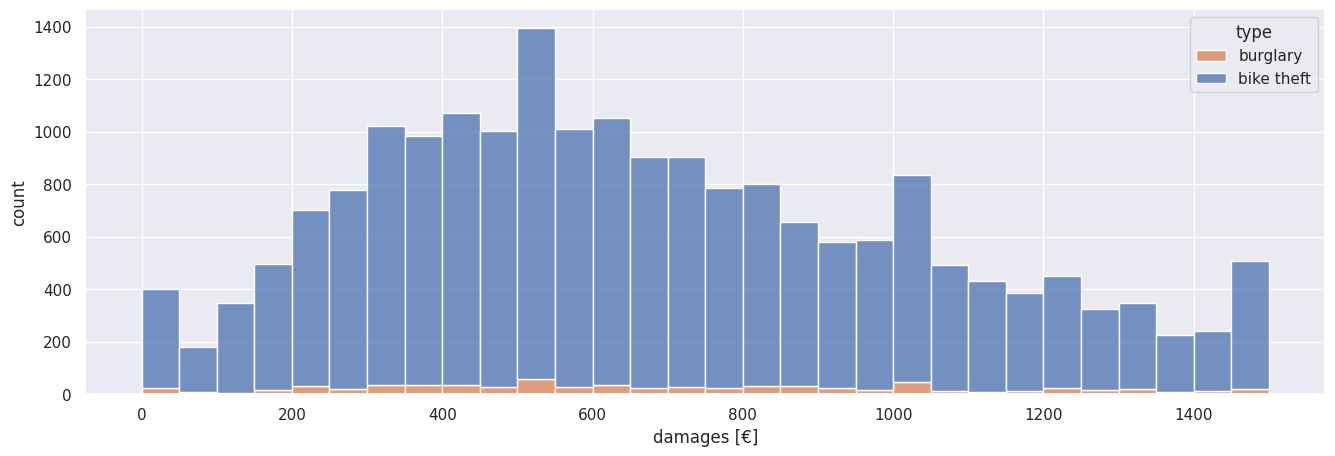

In [13]:
fig, ax = plt.subplots()
sns.histplot(
    data=merged_df,
    x="SCHADENSHOEHE",
    binrange=[0, 1500],
    binwidth=50,
    hue="DELIKT",
    multiple="stack",
    ax=ax,
)
ax.set(xlabel="damages [€]", ylabel="count")
ax.legend(title="type", labels=["burglary", "bike theft"])
plt.show()


### How long does it generally take to commit a crime?
- The graph below indicates quick thefts of less than one hour. 

NOTE: It is possible that a theft has been attributed an arbitrary duration if the duration of the offence is not known. In this case, 0 hours may have been selected as the default.

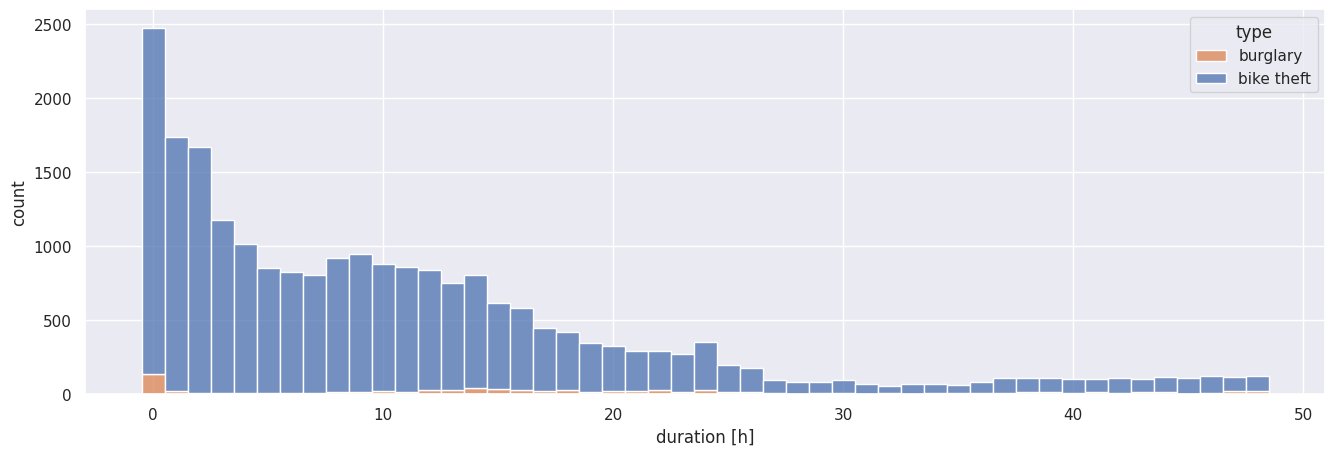

In [14]:
fig, ax = plt.subplots()
sns.histplot(
    data=merged_df,
    x="MAX_TATDAUER_STUNDEN",
    binrange=[0, 48],
    discrete=True,
    hue="DELIKT",
    multiple="stack",
    # cumulative=True,
)
ax.set(xlabel="duration [h]", ylabel="count")
ax.legend(title="type", labels=["burglary", "bike theft"])
plt.show()


From the plot above we can see that a bike theft is usually done somewhere in the span of 0-3h.
To estimate bike theft rush hours we will now observe only thefts that have the somewhat accurate timewindow of 0-3h.

In [15]:
merged_df_quick_observation = merged_df[merged_df["MAX_TATDAUER_STUNDEN"] <= 3]

### When do thefts generally take place?
- The most frequent thefts take place between
    - 17-19 in the evening
- The most frequent burglaries take place between
    - 10-20 

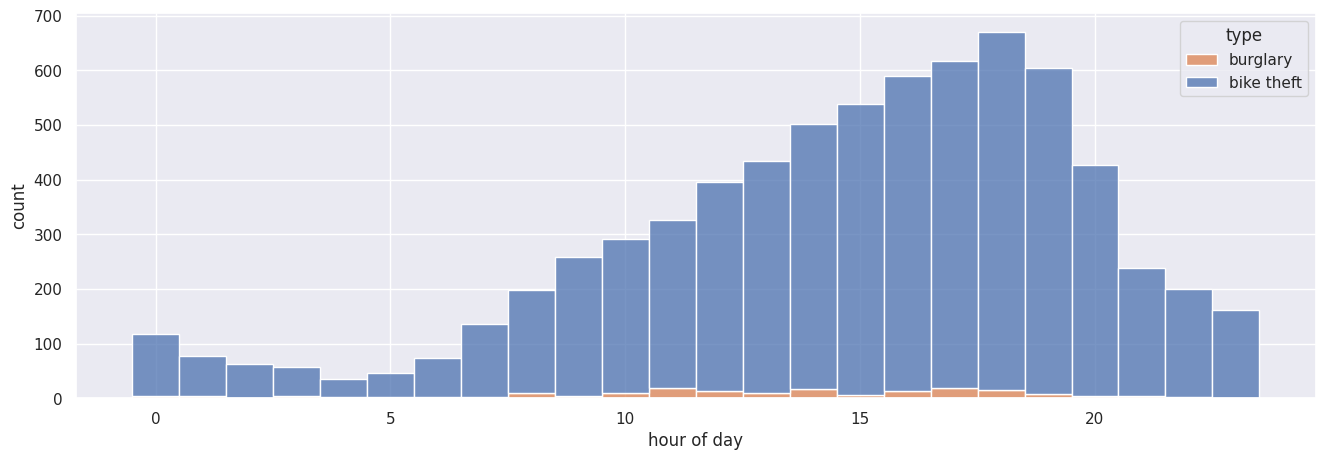

In [16]:
fig, ax = plt.subplots()

sns.histplot(
    data=merged_df_quick_observation,
    x="ZULETZT_GESEHEN_STUNDE",
    discrete=True,
    hue="DELIKT",
    multiple="stack",
    ax=ax,
)
ax.set(xlabel="hour of day", ylabel="count")
ax.legend(title="type", labels=["burglary", "bike theft"])
plt.show()


### When do people usually realize the thefts?
- People seem to mostly realize the thefts in the usual commuting hours
    - 8-10 in the morning
    - 16-18 in the evening

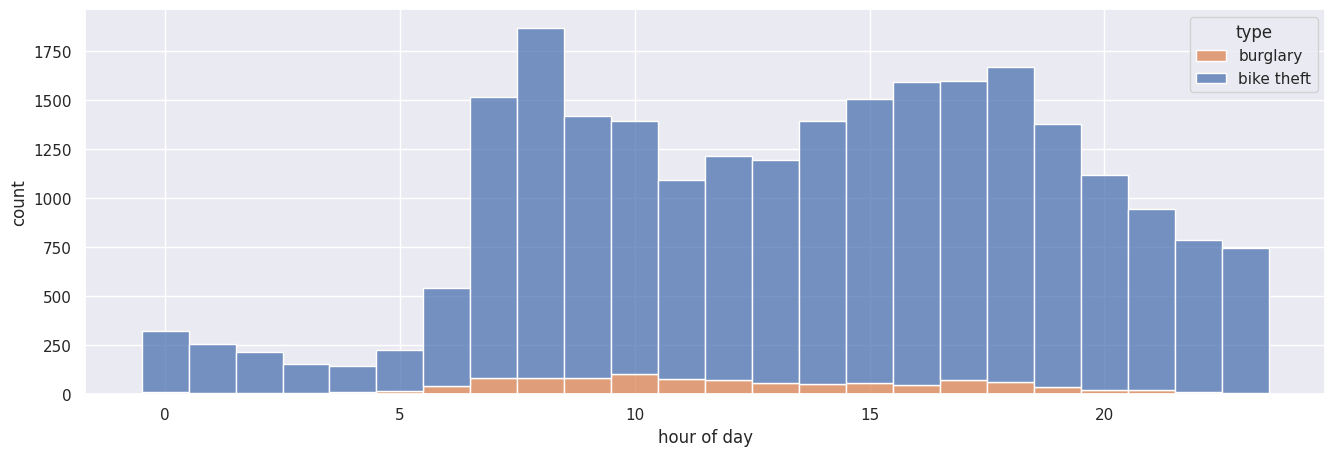

In [17]:
fig, ax = plt.subplots()

sns.histplot(
    data=merged_df,
    x="TAT_BEMERKT_STUNDE",
    discrete=True,
    hue="DELIKT",
    multiple="stack",
    ax=ax,
)
ax.set(xlabel="hour of day", ylabel="count")
ax.legend(title="type", labels=["burglary", "bike theft"])
plt.show()

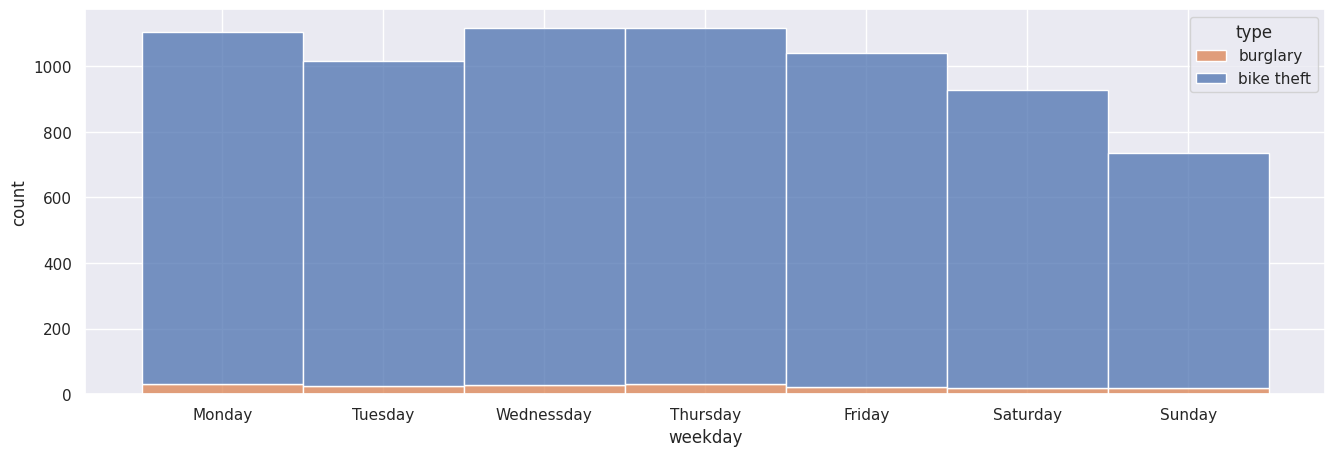

In [18]:
fig, ax = plt.subplots()
sns.histplot(
    data=merged_df_quick_observation,
    x=merged_df_quick_observation.ZULETZT_GESEHEN_DATUM.dt.day_of_week,
    discrete=True,
    hue="DELIKT",
    multiple="stack",
    ax=ax,
)
ax.set_xticks(
    [0, 1, 2, 3, 4, 5, 6],
    ["Monday", "Tuesday", "Wednessday", "Thursday", "Friday", "Saturday", "Sunday"],
)
ax.set(xlabel="weekday", ylabel="count")
ax.legend(title="type", labels=["burglary", "bike theft"])
plt.show()


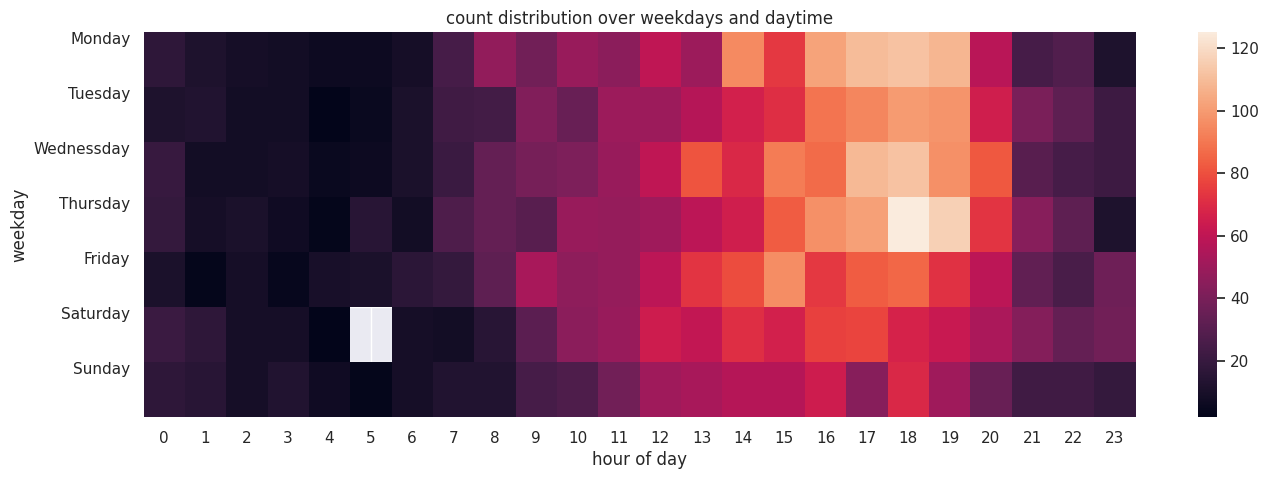

In [19]:
fig, ax = plt.subplots()
sns.heatmap(
    data=pd.DataFrame(
        {
            "day": merged_df_quick_observation.ZULETZT_GESEHEN_DATUM.dt.day_of_week,
            "hour": merged_df_quick_observation.ZULETZT_GESEHEN_DATUM.dt.hour,
        }
    )
    .groupby(["day", "hour"], as_index=False)
    .value_counts()
    .reset_index()
    .pivot(index="day", columns="hour", values="count")
)
ax.set_yticks(
    [0, 1, 2, 3, 4, 5, 6],
    ["Monday", "Tuesday", "Wednessday", "Thursday", "Friday", "Saturday", "Sunday"],
    rotation=0,
    va="top",
)
ax.set(
    xlabel="hour of day",
    ylabel="weekday",
    title="count distribution over weekdays and daytime",
)
plt.show()


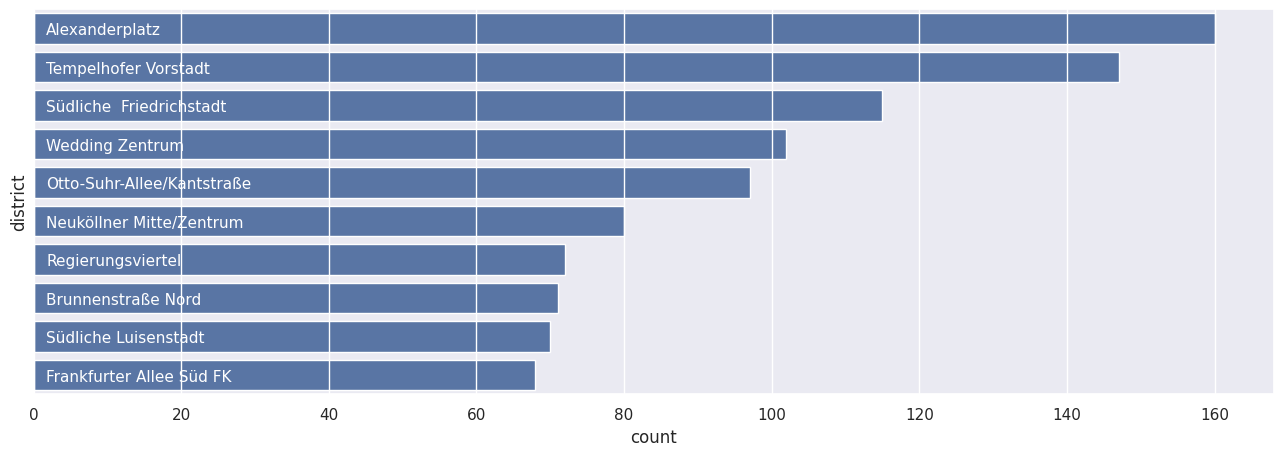

In [20]:
plot_df = merged_df_quick_observation[
    (merged_df_quick_observation.ZULETZT_GESEHEN_STUNDE.isin([15, 16, 17, 18, 19, 20]))
    & (merged_df_quick_observation.ZULETZT_GESEHEN_DATUM.dt.day_of_week.isin([0, 1, 2, 3, 4, 5]))
]
plot_df = (
    plot_df.groupby("BZR_NAME")
    .agg({"ANGELEGT_AM": "count", "SCHADENSHOEHE": "sum"})
    .sort_values(by=("ANGELEGT_AM"), ascending=False)
    .head(10)
    .reset_index()
)
with plt.rc_context({"axes.axisbelow": "line"}):
    fig, ax1 = plt.subplots()
    sns.barplot(data=plot_df, y="BZR_NAME", x="ANGELEGT_AM", ax=ax1, color="#4c72b0")
    ax1.set(xlabel="count", ylabel="district")
    ax1.set_yticklabels(plot_df.BZR_NAME, ha="left", fontdict={"color": "white"})
    ax1.yaxis.set_tick_params(pad=-15)
    plt.show()


### Which bikes are most often reported as stolen?
- In the data, the generic terms *men's* and *women's bicycles* are most frequently represented, but these could also be understood as a generic term for other types, such as mountain bike, trekking bike, etc.

In [21]:
merged_df.groupby(["ART_DES_FAHRRADS"]).agg(
    {"SCHADENSHOEHE": ["count", "sum", "max"]}
).sort_values(by=("SCHADENSHOEHE", "count"), ascending=False)


SCHADENSHOEHE                     
                          count         sum      max
ART_DES_FAHRRADS                                    
Herrenfahrrad             11413  12470159.0   9900.0
Damenfahrrad               6562   5951997.0  10000.0
Fahrrad                    3364   4195824.0   9799.0
Mountainbike               1008    847169.0   8000.0
Kinderfahrrad               934    386540.0   1950.0
diverse Fahrräder           630   1261089.0  10000.0
Rennrad                     352    411202.0   8500.0
Lastenfahrrad                60    152369.0   9000.0

### Are there seasonal peak times for offences?
- Apparently there are fewer reported thefts in the cold months of Dec-March.
    - Assumption: people put unused bikes in cellars, generally ride less --> fewer casual thefts

/tmp/ipykernel_58301/4249267223.py:2: UserWarning: The palette list has more values (20) than needed (12), which may not be intended.
  sns.histplot(
/tmp/ipykernel_58301/4249267223.py:16: UserWarning: The palette list has more values (20) than needed (12), which may not be intended.
  sns.histplot(


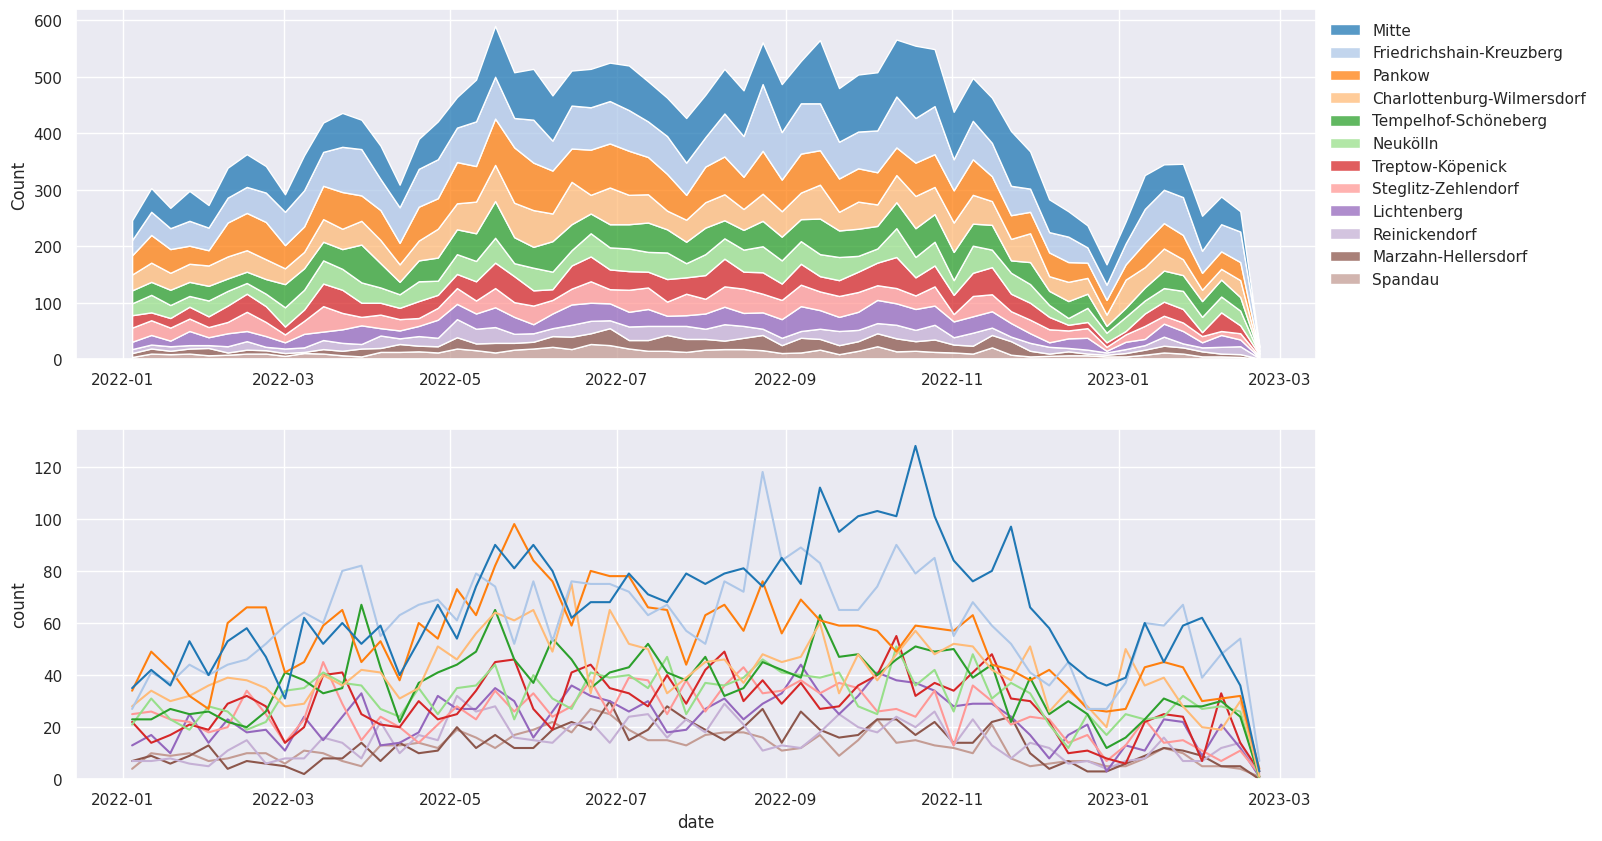

In [22]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16, 10))
sns.histplot(
    ax=ax1,
    data=merged_df,
    x="ZULETZT_GESEHEN_DATUM",
    element="poly",
    hue="BEZIRK",
    hue_order=merged_df.groupby("BEZIRK")
    .agg({"LOR": "count"})
    .sort_values(by="LOR", ascending=False)
    .index.to_list(),
    multiple="stack",
    binwidth=7,
    palette=sns.color_palette("tab20"),
)
sns.histplot(
    ax=ax2,
    data=merged_df,
    x="ZULETZT_GESEHEN_DATUM",
    element="poly",
    fill=False,
    hue="BEZIRK",
    hue_order=merged_df.groupby("BEZIRK")
    .agg({"LOR": "count"})
    .sort_values(by="LOR", ascending=False)
    .index.to_list(),
    binwidth=7,
    palette=sns.color_palette("tab20"),
    legend=False,
)
sns.move_legend(
    ax1,
    "upper left",
    bbox_to_anchor=(1, 1),
    title=None,
    frameon=False,
)
ax1.set(xlabel=None)
plt.xlabel("date")
plt.ylabel("count")
plt.show()
